In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from PIL import Image

import context
from models.convnext import ConvNeXtIR

set_matplotlib_formats("retina")

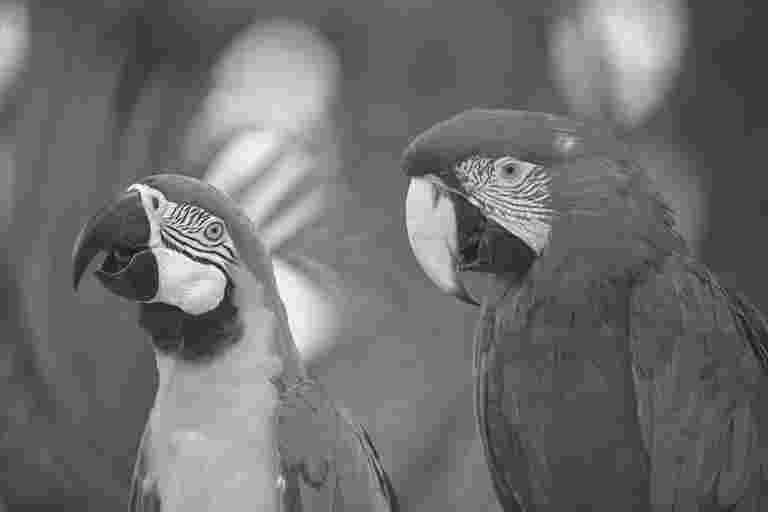

In [2]:
TRAIN_IMAGE = Image.open("../data/Live1-Classic5/live1/gray/qf_10/parrots.jpg")
TRAIN_IMAGE

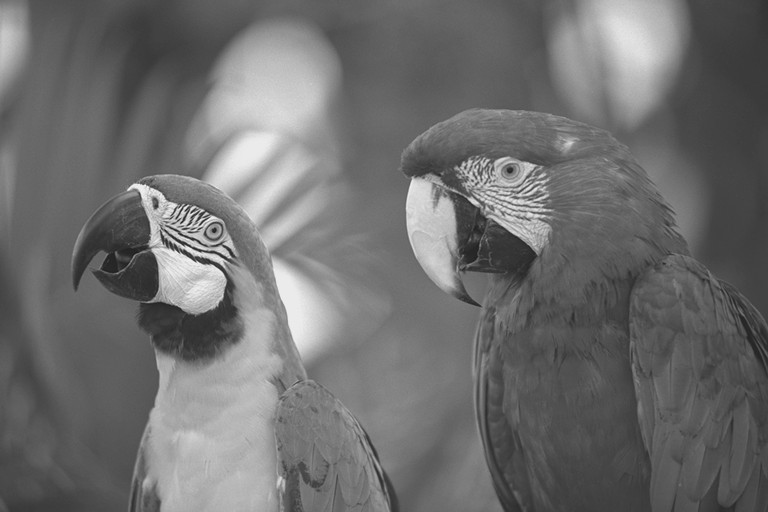

In [3]:
TARGET_IMAGE = Image.open("../data/Live1-Classic5/live1/gray/qf_90/parrots.jpg")
TARGET_IMAGE

In [4]:
model = ConvNeXtIR(in_channels=1, depths=[1,2,1], dims=[32,64,16], layer_scale_init_value=1e-2)
model

ConvNeXtIR(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=32)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=32, out_features=128, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=128, out_features=32, bias=True)
      )
    )
    (1): Sequential(
      (0): Block(
        (dwconv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=64, out_features=256, bias=True)
  

In [6]:
state_dict = torch.load("../checkpoints/ConvNeXtIR-tiny-luma-test/checkpoint_2900.pth")["model"]
model.load_state_dict(state_dict)

/var/folders/89/b5lh60hs3x1g1db4v2dx04980000gn/T/ipykernel_25507/2865495579.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("../checkpoints/ConvN

<All keys matched successfully>

### Initialize dataset

In [7]:
toten = torchvision.transforms.ToTensor()
batch = (toten(TRAIN_IMAGE).unsqueeze(0), toten(TARGET_IMAGE).unsqueeze(0))

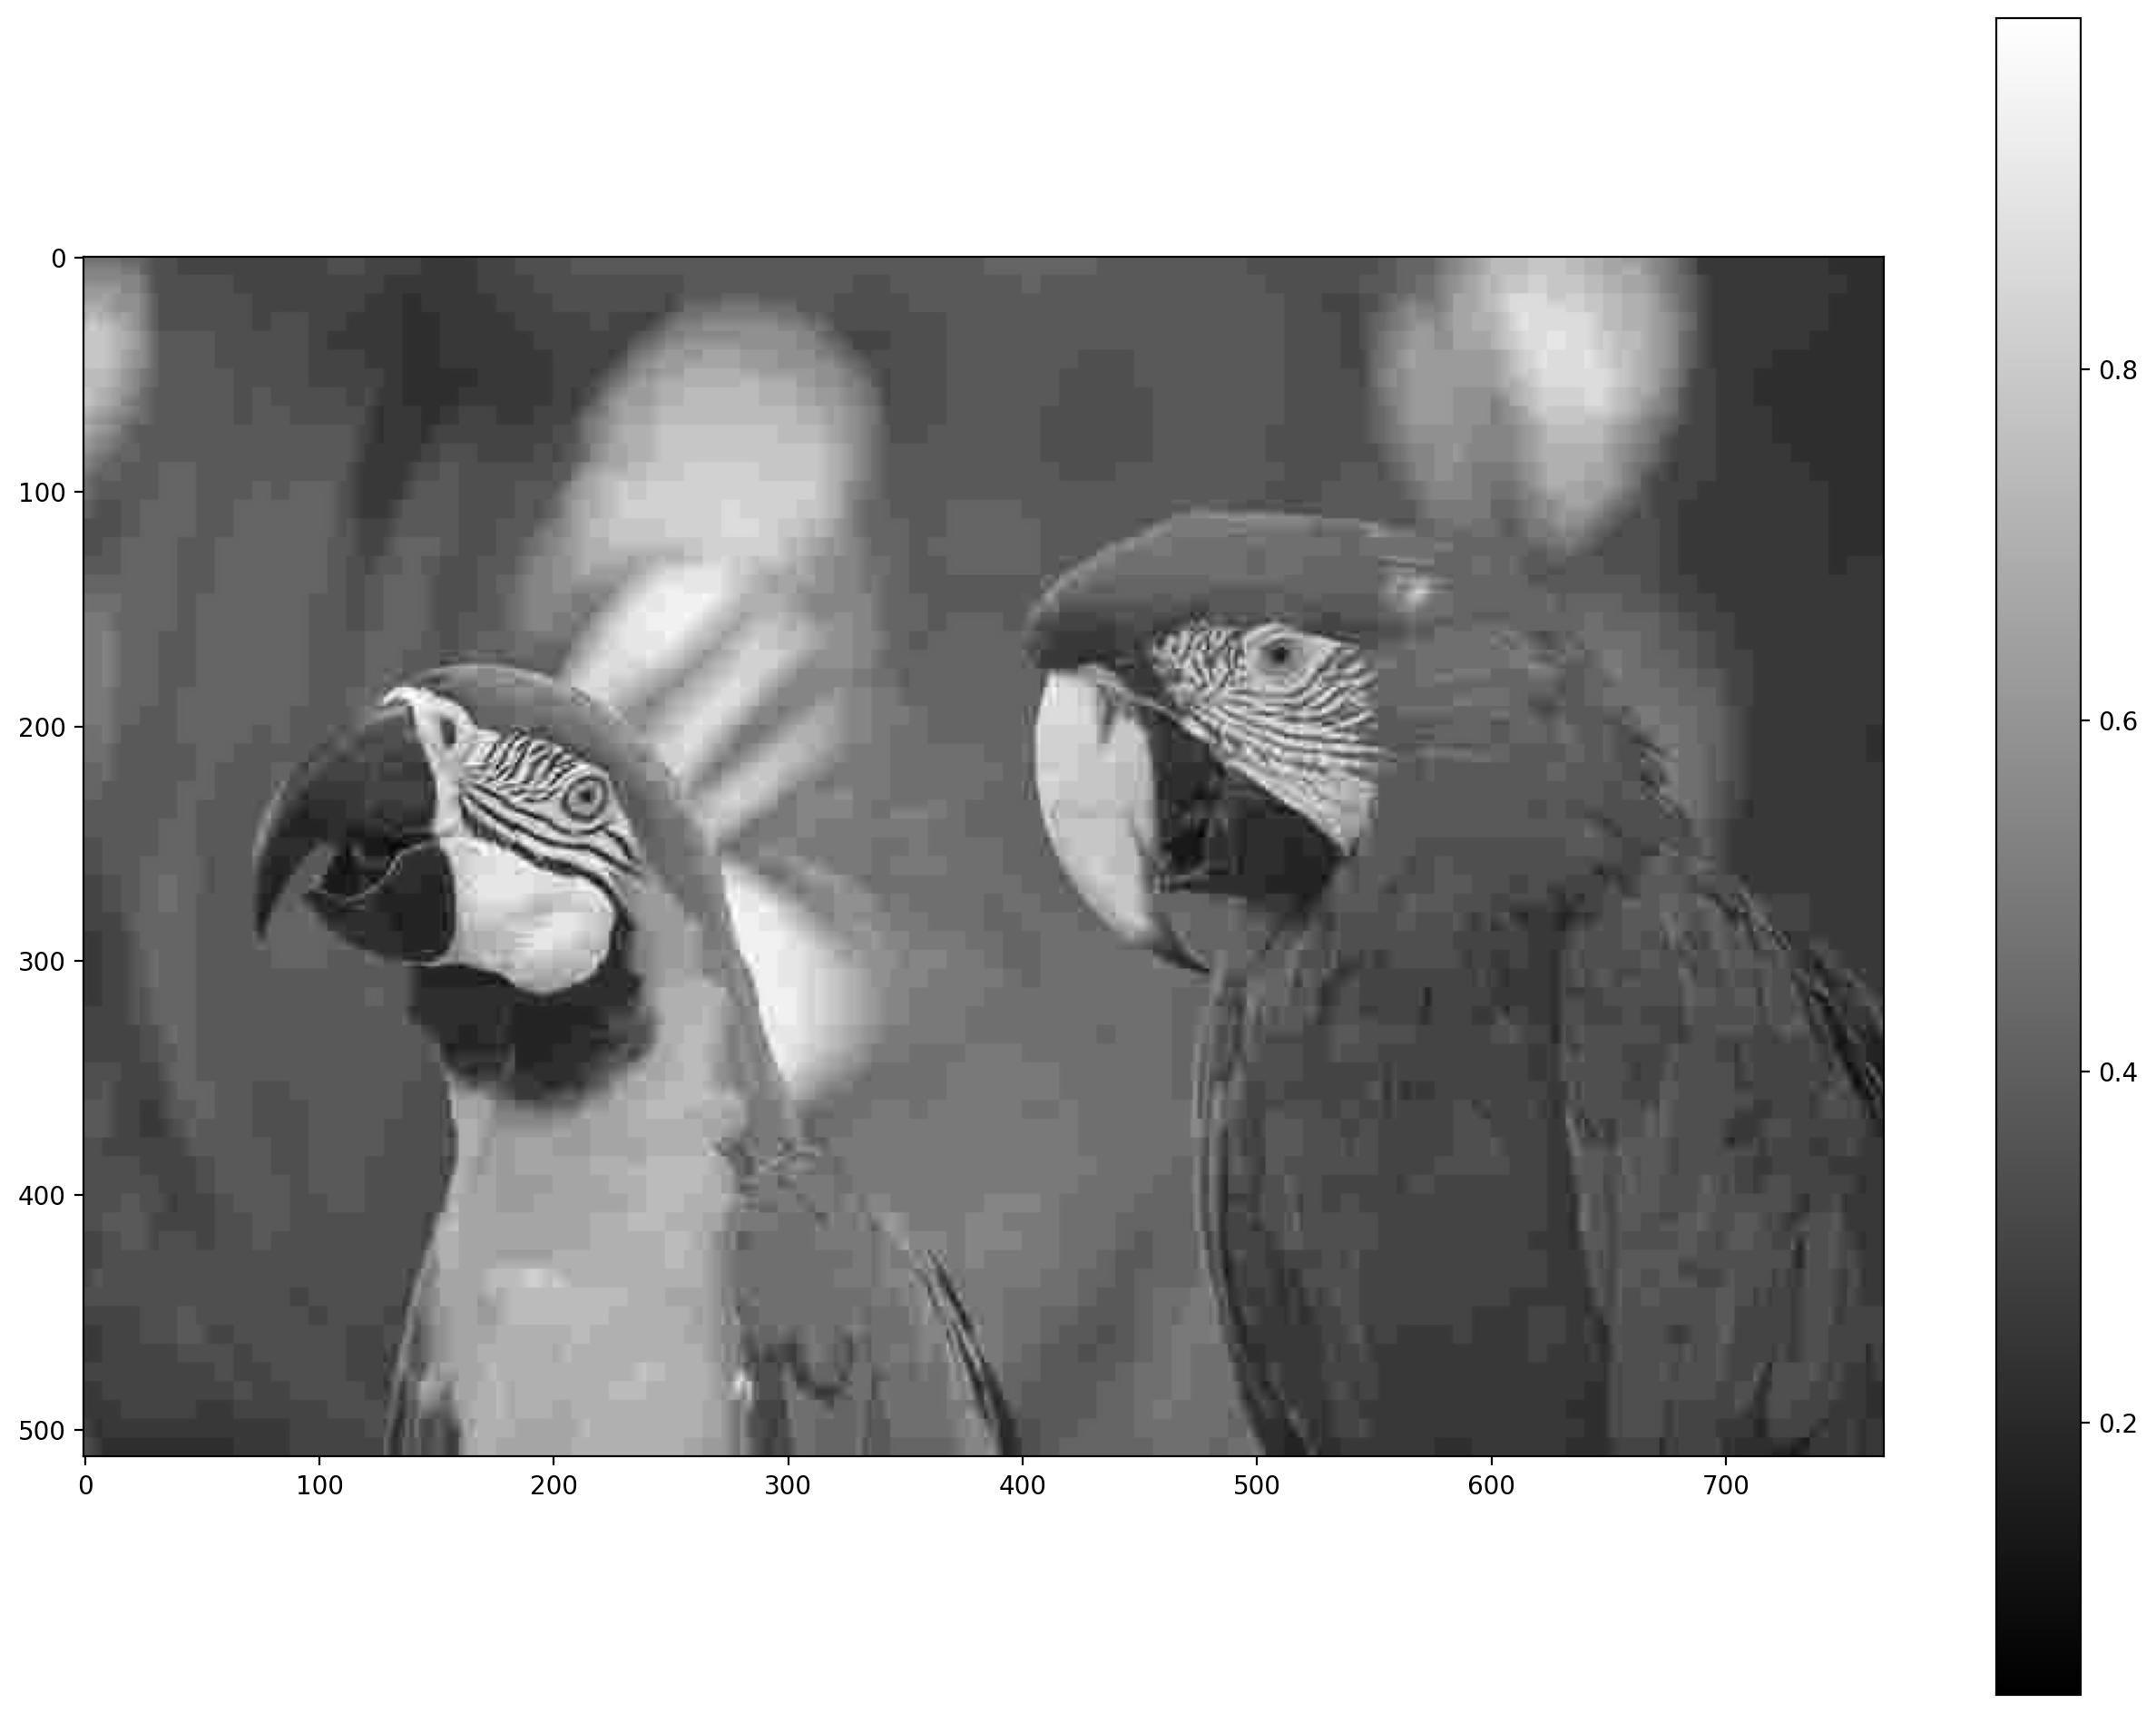

In [9]:
y = model(batch[0])
fig, ax = plt.subplots(figsize=(16,12))
c = ax.imshow(y[0,0].detach().numpy(), cmap="gray")
fig.colorbar(c)

In [10]:
mps = torch.device("mps")

In [13]:
batch = (batch[0].to(device=mps), batch[1].to(device=mps))
model = model.to(device=mps)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [19]:
pred_history = []

for i in range(10_000):
    optim.zero_grad()
    train, target = batch
    pred = model(train)
    loss = torch.nn.functional.mse_loss(pred, target, reduction="mean")
    loss.backward()
    optim.step()
    if i % 10 == 0:
        print(f"Train iteration [{i:>5}/{4000:>5}]: loss={loss.item():.6f}")
        pred_history.append(pred.detach().cpu().numpy()[0,0])

Train iteration [    0/ 4000]: loss=0.058216
Train iteration [   10/ 4000]: loss=0.037347


KeyboardInterrupt: 

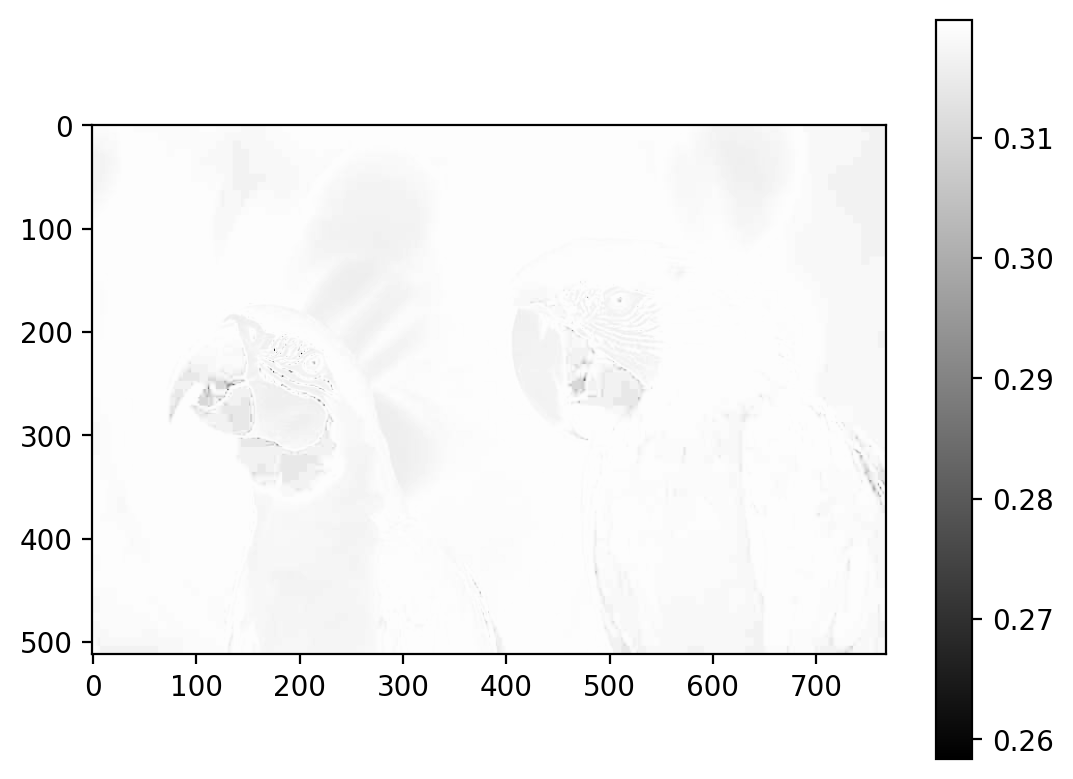

In [21]:
c = plt.imshow(pred_history[-1], cmap="gray")
plt.colorbar(c)